In [1]:
import sys
sys.path.append('../')
from src import mlp_quantile
from src import metrics as _metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import seaborn as sns

sns.set(rc={'figure.figsize':(20,8)})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
pd.set_option('display.max_rows', 120)

## Reading / Displaying the Data 

In [2]:
df_dataset_v2 = pd.read_csv('../data/forecast_dataset_exp13.csv')

In [3]:
df_dataset_v2.describe()

,month,unit_price,unit_perc_tax_substitution,Y,hc_cluster_1,hc_cluster_2,hc_cluster_3,hc_cluster_4,hc_cluster_5,hc_cluster_6,...,cat_code_1,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10
count,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,...,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000
mean,6.318052,235.343453,6.592531,108.926934,0.349570,0.491404,0.012178,0.018625,0.017192,0.018625,...,0.010029,0.005014,0.007880,0.063037,0.018625,0.018625,0.006447,0.007880,0.009312,0.012178
std,3.471418,212.669079,4.198880,235.188518,0.477005,0.500105,0.109718,0.135244,0.130033,0.135244,...,0.099675,0.070659,0.088449,0.243117,0.135244,0.135244,0.080063,0.088449,0.096084,0.109718
min,1.000000,6.910000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,114.035417,3.555228,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,175.671332,6.817621,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.000000,286.890767,9.471641,90.250000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,12.000000,1903.950000,22.910000,2063.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
df_dataset_v2.head()

,code,year_month,month,unit_price,unit_perc_tax_substitution,Y,hc_cluster_1,hc_cluster_2,hc_cluster_3,hc_cluster_4,...,cat_code_1,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10
0,0671c2b9132a3f5215a4212ce0691694,2016-11,11,205.618941,11.113689,664,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0671c2b9132a3f5215a4212ce0691694,2016-12,12,245.817299,7.586042,225,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0671c2b9132a3f5215a4212ce0691694,2017-01,1,216.730145,3.697939,211,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0671c2b9132a3f5215a4212ce0691694,2017-02,2,206.905313,2.348998,634,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0671c2b9132a3f5215a4212ce0691694,2017-03,3,199.342329,6.918881,1343,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_cols = [c for c in df_dataset_v2.columns if c not in ['year_month', 'Y'] and 'hc_cluster' not in c]

In [6]:
df_dataset_v2['code'] = df_dataset_v2['code'].astype('category').cat.codes

In [7]:
X_cols

['code',
 'month',
 'unit_price',
 'unit_perc_tax_substitution',
 'kmeans_cluster_0',
 'kmeans_cluster_1',
 'kmeans_cluster_2',
 'kmeans_cluster_3',
 'kmeans_cluster_4',
 'kmeans_cluster_5',
 'kmeans_cluster_6',
 'kmeans_cluster_7',
 'kmeans_cluster_8',
 'cat_code_0',
 'cat_code_1',
 'cat_code_2',
 'cat_code_3',
 'cat_code_4',
 'cat_code_5',
 'cat_code_6',
 'cat_code_7',
 'cat_code_8',
 'cat_code_9',
 'cat_code_10']

In [8]:
df_dataset_v2[X_cols].head()

,code,month,unit_price,unit_perc_tax_substitution,kmeans_cluster_0,kmeans_cluster_1,kmeans_cluster_2,kmeans_cluster_3,kmeans_cluster_4,kmeans_cluster_5,...,cat_code_1,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10
0,0,11,205.618941,11.113689,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,12,245.817299,7.586042,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,216.730145,3.697939,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,206.905313,2.348998,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,3,199.342329,6.918881,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Splitting the Sets
* We will use the temporal series cross validation
* 3 months minimum intervals
* 3 training, 6 validation, 3 test
* 4 training, 5 validation, 3 test
* 5 training, 4 validation, 3 test
* 6 training, 3 validation, 3 test

In [9]:
df_train_val_test = pd.read_csv('../data/train_val_test.csv')

In [10]:
df_train_val_test

,set,train,val,reserved
0,0,"['2016-06', '2016-07', '2016-08']","['2016-09', '2016-10', '2016-11', '2016-12', '...",False
1,1,"['2016-06', '2016-07', '2016-08', '2016-09']","['2016-10', '2016-11', '2016-12', '2017-01', '...",False
2,2,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2016-11', '2016-12', '2017-01', '2017-02']",False
3,3,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2016-12', '2017-01', '2017-02']",False
4,4,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2017-01', '2017-02']",False
5,5,"['2016-06', '2016-07', '2016-08', '2016-09', '...",['2017-02'],False
6,6,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2017-03', '2017-04', '2017-05']",True


## Regressors Init

In [11]:
regressors = {}
RANDOM_STATE = 42
q =0.5

In [12]:
import lightgbm as lgb
gbm = lgb.LGBMRegressor(random_state=RANDOM_STATE)
regressors['gbm'] = gbm

In [13]:
import lightgbm as lgb
gbm_q = lgb.LGBMRegressor(alpha=q, objective = 'quantile',
    metric = 'quantile',random_state=RANDOM_STATE)
regressors['gbm_q'] = gbm_q

In [14]:
from sklearn.ensemble import GradientBoostingRegressor
gb_q = GradientBoostingRegressor(loss='quantile', alpha=q)
regressors['gb_q'] = gb_q

In [15]:

# mlp_q = mlp_quantile.QuantileModel(input_dims=len(X_cols), q=q)
# regressors['mlp_q'] = mlp_q

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Train Eval



In [17]:
def parse_str_list(str_list):
    result = str_list.replace("'","").replace('[','').replace(']','').replace(' ', '').split(',')
    return result

In [18]:
sets = list(df_train_val_test[~df_train_val_test.reserved].set.values)
sets

[0, 1, 2, 3, 4, 5]

In [19]:
results = []
for r_name, r in regressors.items():
    for s in sets:
        df_set = df_train_val_test[~df_train_val_test.reserved & (df_train_val_test.set == s)]

        x_scaler = MinMaxScaler()
        
        train_years = parse_str_list(df_set.train.values[0])
        val_years = parse_str_list(df_set.val.values[0])
        print(f'Training {r_name} on set {s}')
        

        df_train = df_dataset_v2[df_dataset_v2.year_month.isin(train_years)]
        df_val = df_dataset_v2[df_dataset_v2.year_month.isin(val_years)]
    
        y_train = df_train['Y'].values    
        y_val = df_val['Y'].values
        
        if 'mlp' in r_name:
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train, 
                       X_val = x_scaler.transform(df_val[X_cols]), y_val = y_val)
        else: 
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train)
        
        print(f'Validating {r_name}  on set {s}')
        
        y_pred_val = r_inst.predict(x_scaler.transform(df_val[X_cols]))
        
        y_pred_val = y_pred_val
        m = _metrics.applyRegressionMetrics(y=y_val, y_pred=y_pred_val)
        m['reg_inst'] = r_inst
        m['r_name'] = r_name
        m['set'] = s
        results.append(m)

    print()
df_results = pd.DataFrame(results)    

Training gbm on set 0
Validating gbm  on set 0
Training gbm on set 1
Validating gbm  on set 1
Training gbm on set 2
Validating gbm  on set 2
Training gbm on set 3
Validating gbm  on set 3
Training gbm on set 4
Validating gbm  on set 4
Training gbm on set 5
Validating gbm  on set 5

Training gbm_q on set 0
Validating gbm_q  on set 0
Training gbm_q on set 1
Validating gbm_q  on set 1
Training gbm_q on set 2
Validating gbm_q  on set 2
Training gbm_q on set 3
Validating gbm_q  on set 3
Training gbm_q on set 4
Validating gbm_q  on set 4
Training gbm_q on set 5
Validating gbm_q  on set 5

Training gb_q on set 0
Validating gb_q  on set 0
Training gb_q on set 1
Validating gb_q  on set 1
Training gb_q on set 2
Validating gb_q  on set 2
Training gb_q on set 3
Validating gb_q  on set 3
Training gb_q on set 4
Validating gb_q  on set 4
Training gb_q on set 5
Validating gb_q  on set 5



In [20]:
metric_list = []

In [21]:
df_results.groupby('r_name').agg({'RMSE':[pd.Series.mean, pd.Series.std],
                                  'MDAPE':[pd.Series.mean, pd.Series.std],'MAPE':[pd.Series.mean, pd.Series.std],
                                  'MSE':[pd.Series.mean, pd.Series.std],
                                  'MAE':[pd.Series.mean, pd.Series.std],'R2':[pd.Series.mean, pd.Series.std],})

RMSE                MDAPE                MAPE            \
              mean        std      mean       std      mean       std   
r_name                                                                  
gb_q    194.081020  27.434479  0.661563  0.061477  1.988598  0.463121   
gbm     162.634552  18.720890  0.962770  0.119370  4.229230  0.851877   
gbm_q   190.070892  29.713034  0.699942  0.052913  2.037769  0.135976   

                 MSE                      MAE                   R2            
                mean           std       mean        std      mean       std  
r_name                                                                        
gb_q    38294.651169  10087.137136  81.628373  13.824528  0.301815  0.092845  
gbm     26742.057216   5841.785379  92.380220  13.441189  0.507791  0.057022  
gbm_q   36862.664291  10545.911634  82.627708  13.061725  0.331977  0.103037

Training gbm on set 6
Validating gbm on set 6 and 2017-03
932 125
RMSE : 175.7511
MAPE': 3.6098
MDAPE': 0.8770
MSE: 30888.4560
MAE: 86.7600
R2: 0.4505


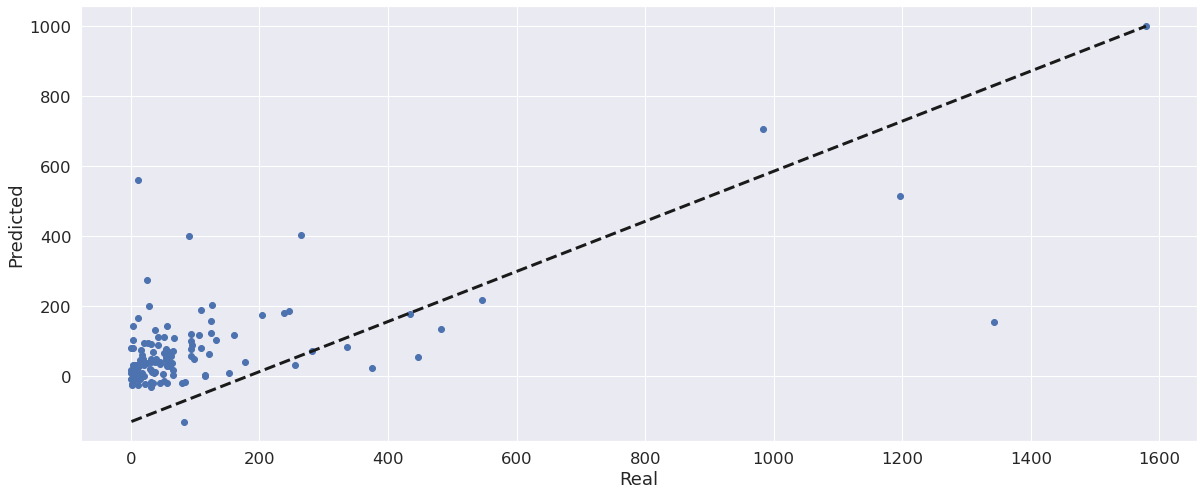

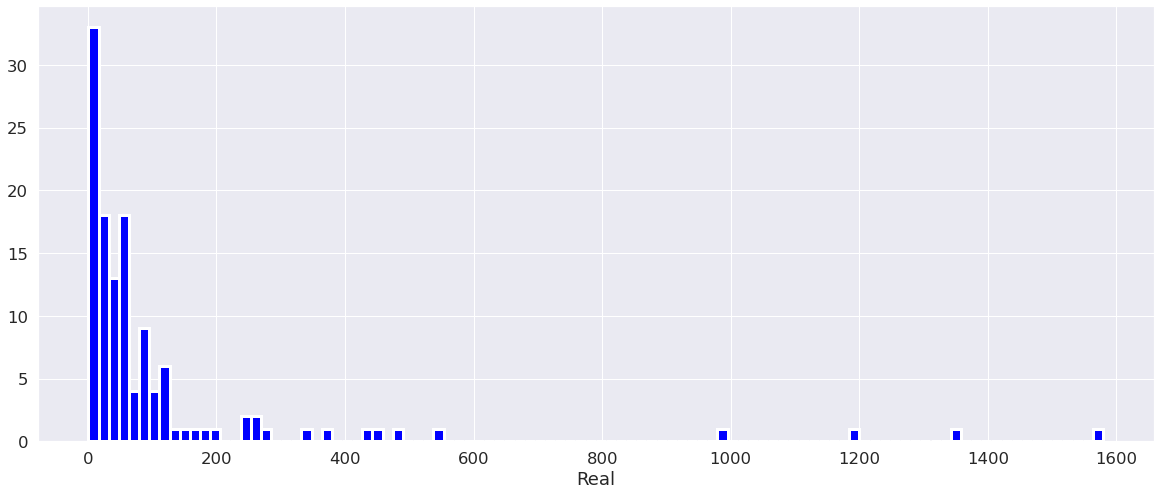

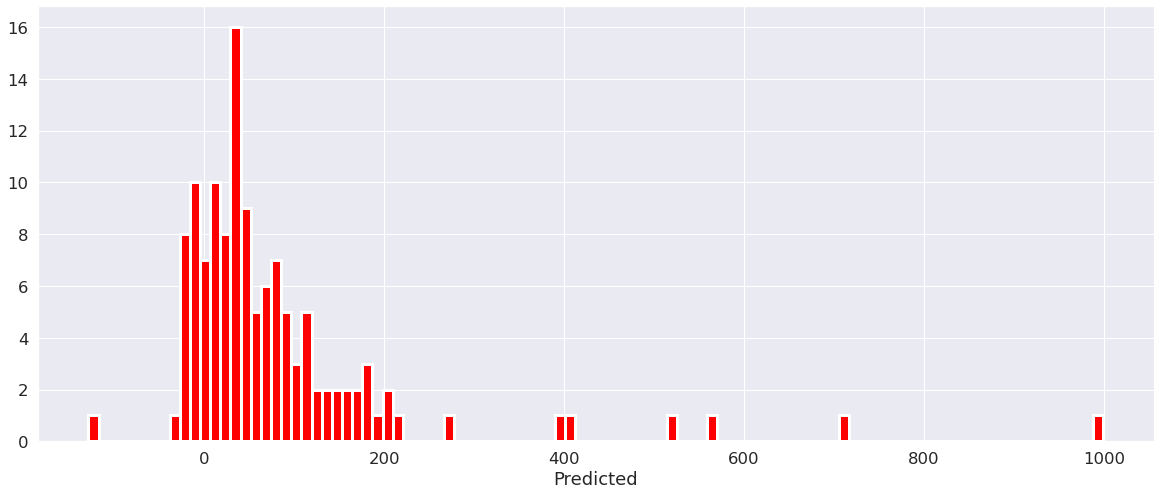


Validating gbm on set 6 and 2017-04
932 122
RMSE : 139.1013
MAPE': 3.0526
MDAPE': 0.8009
MSE: 19349.1721
MAE: 73.8115
R2: 0.6044


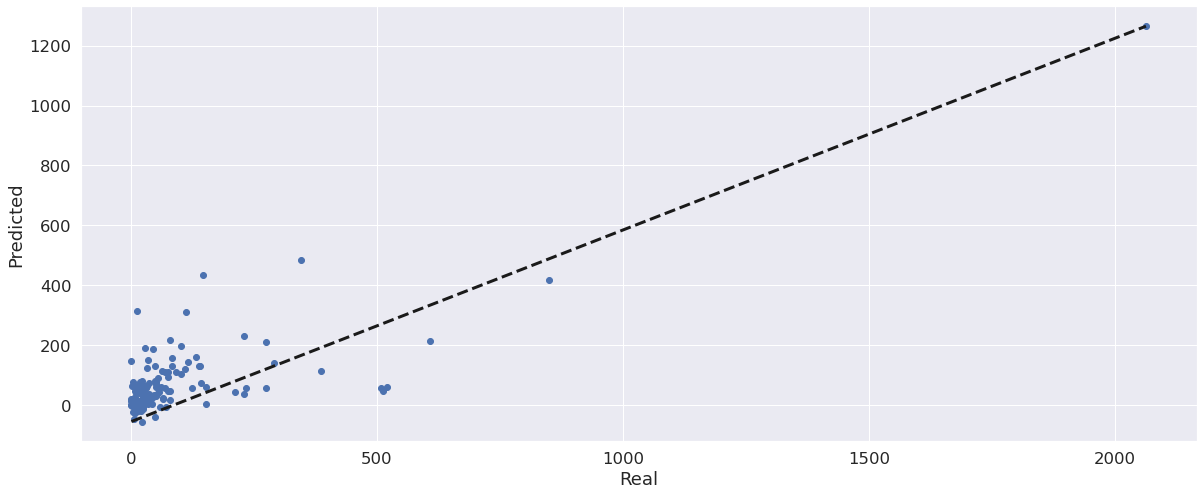

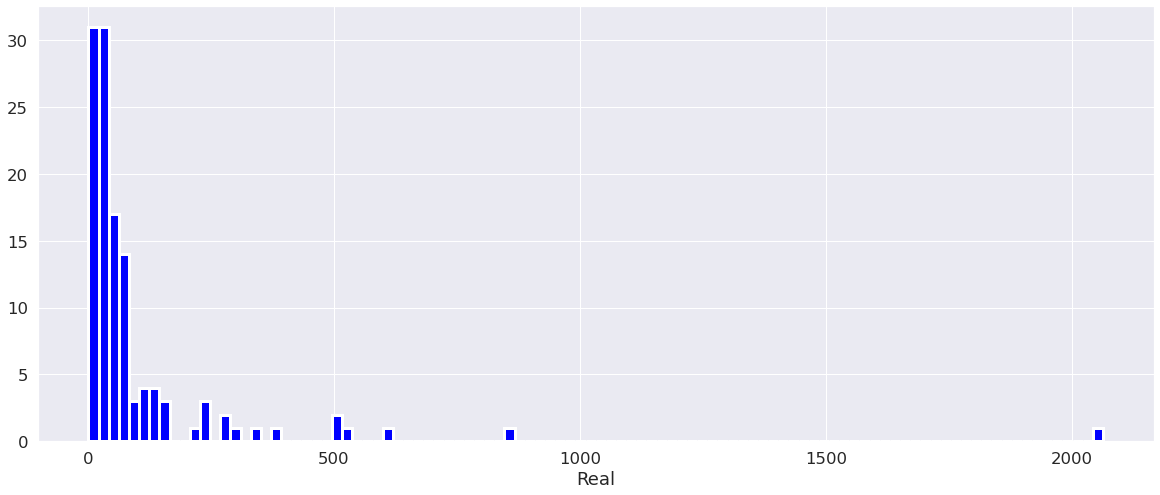

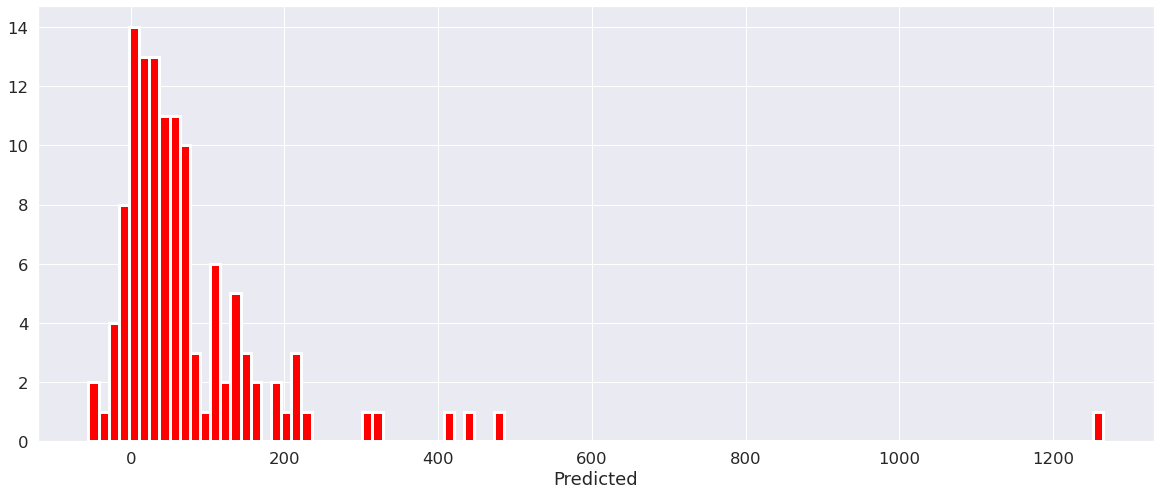


Validating gbm on set 6 and 2017-05
932 121
RMSE : 201.0299
MAPE': 1.8179
MDAPE': 0.7391
MSE: 40413.0165
MAE: 104.0744
R2: 0.4580


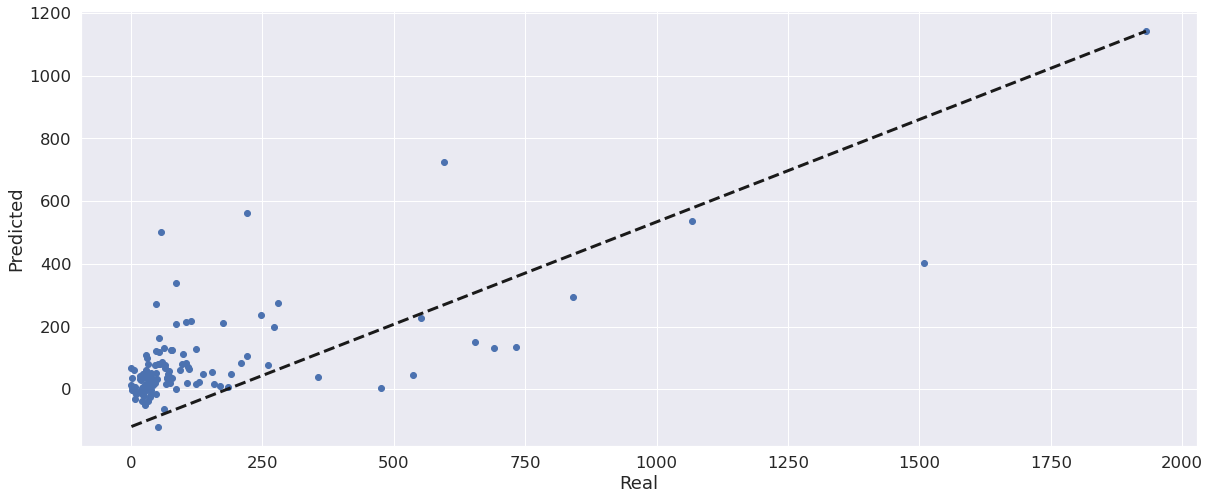

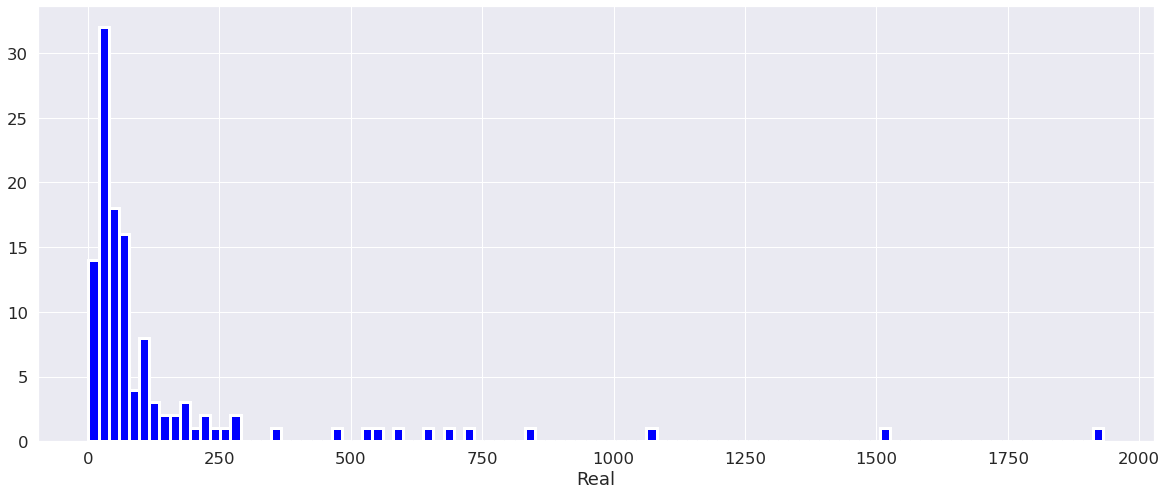

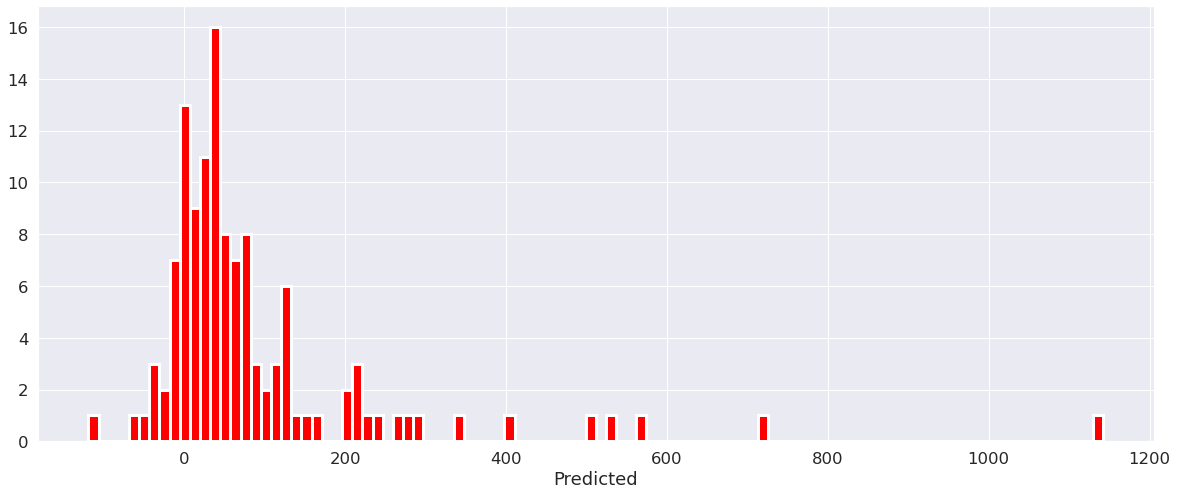


Training gbm_q on set 6
Validating gbm_q on set 6 and 2017-03
932 125
RMSE : 192.8619
MAPE': 2.2463
MDAPE': 0.5054
MSE: 37195.7120
MAE: 75.9840
R2: 0.3383


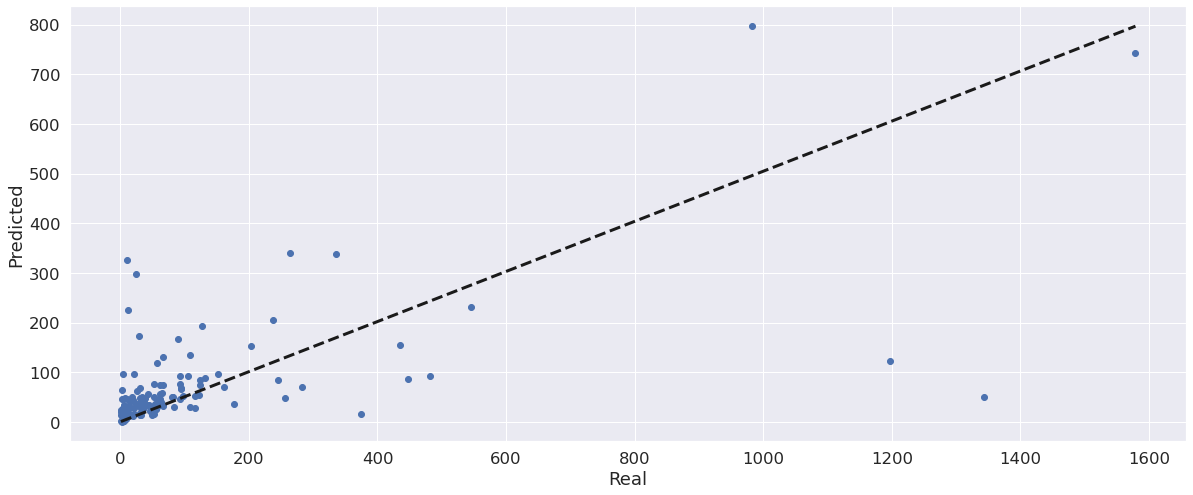

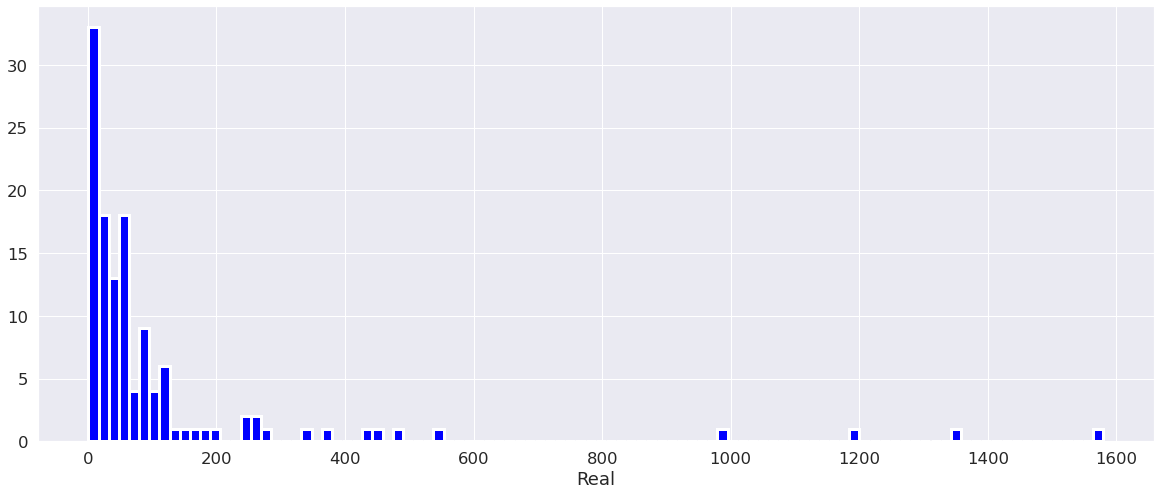

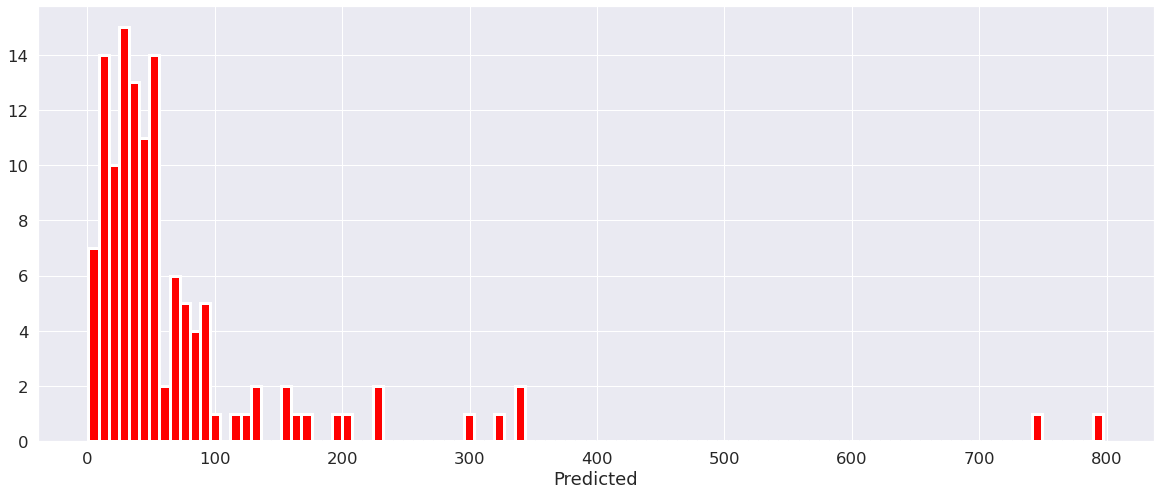


Validating gbm_q on set 6 and 2017-04
932 122
RMSE : 154.8696
MAPE': 1.2948
MDAPE': 0.5044
MSE: 23984.5984
MAE: 65.5000
R2: 0.5096


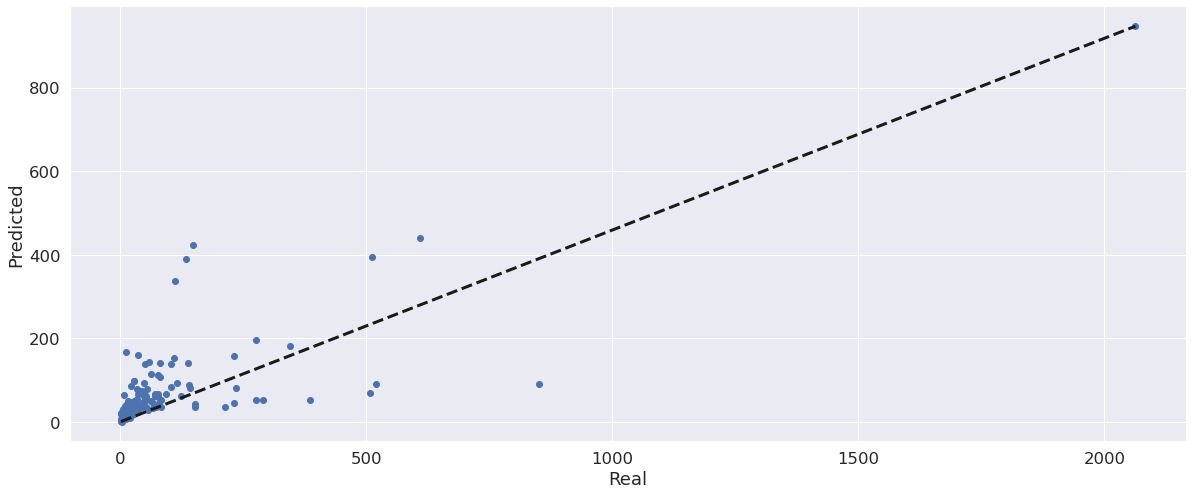

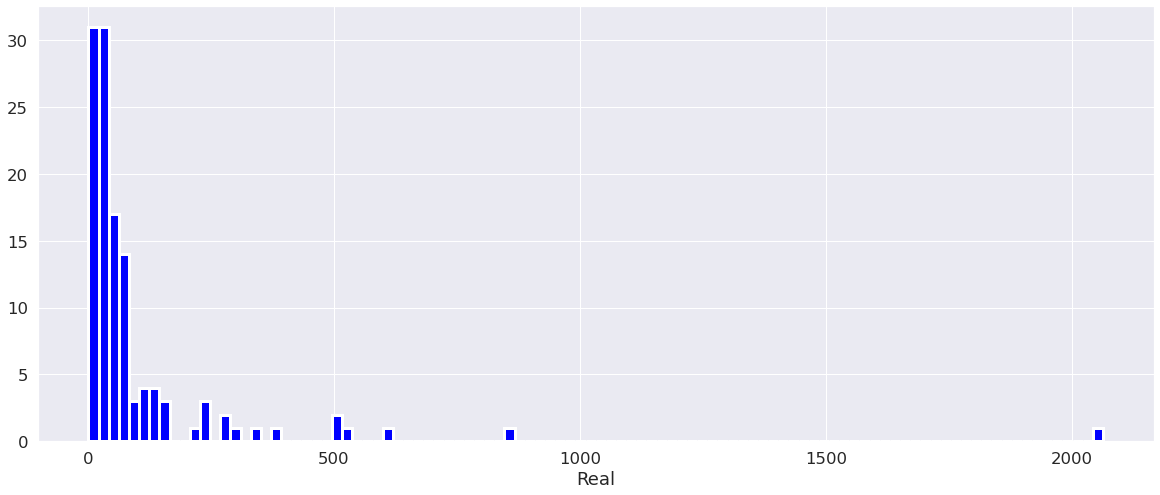

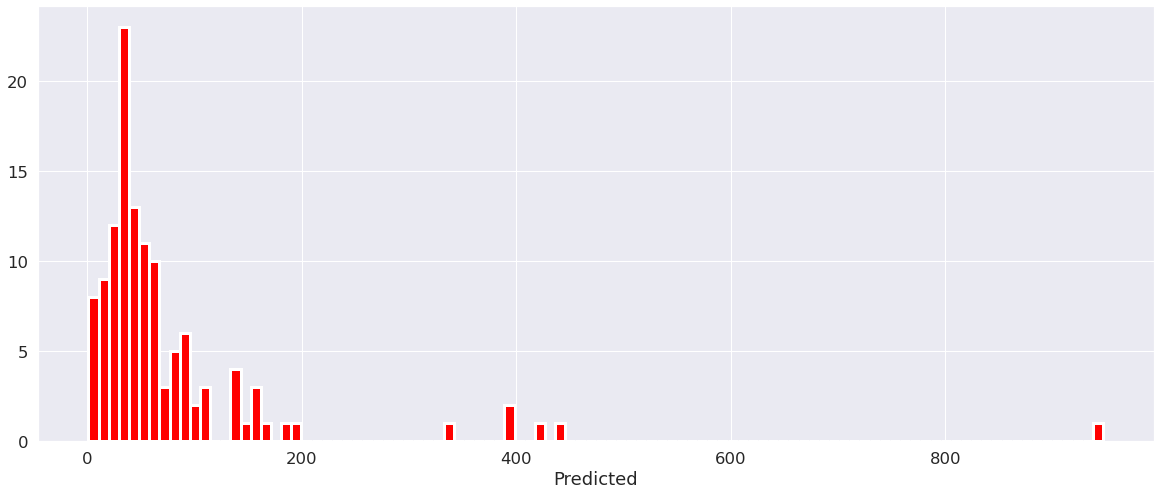


Validating gbm_q on set 6 and 2017-05
932 121
RMSE : 218.3044
MAPE': 1.0752
MDAPE': 0.5672
MSE: 47656.8099
MAE: 93.2397
R2: 0.3608


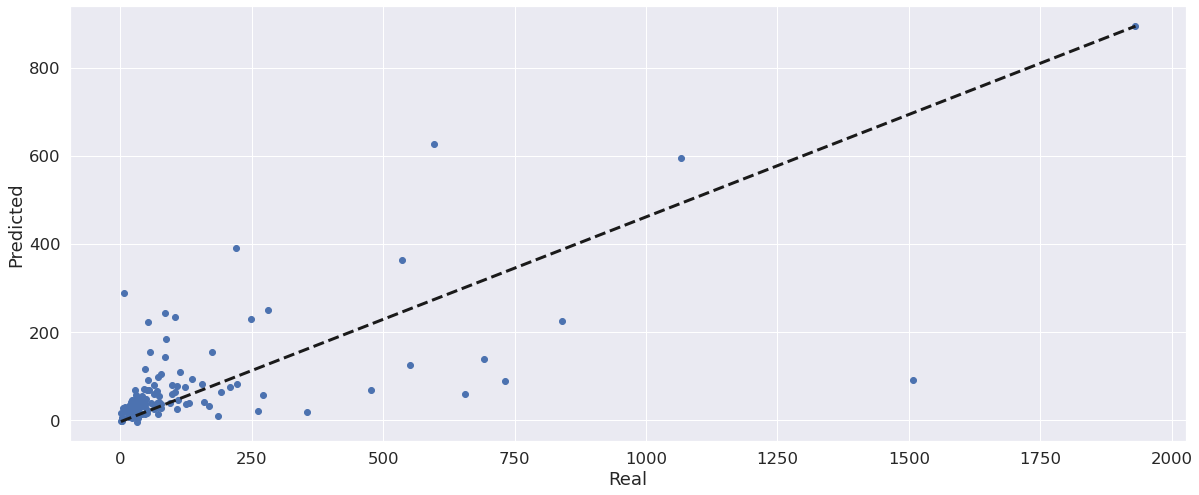

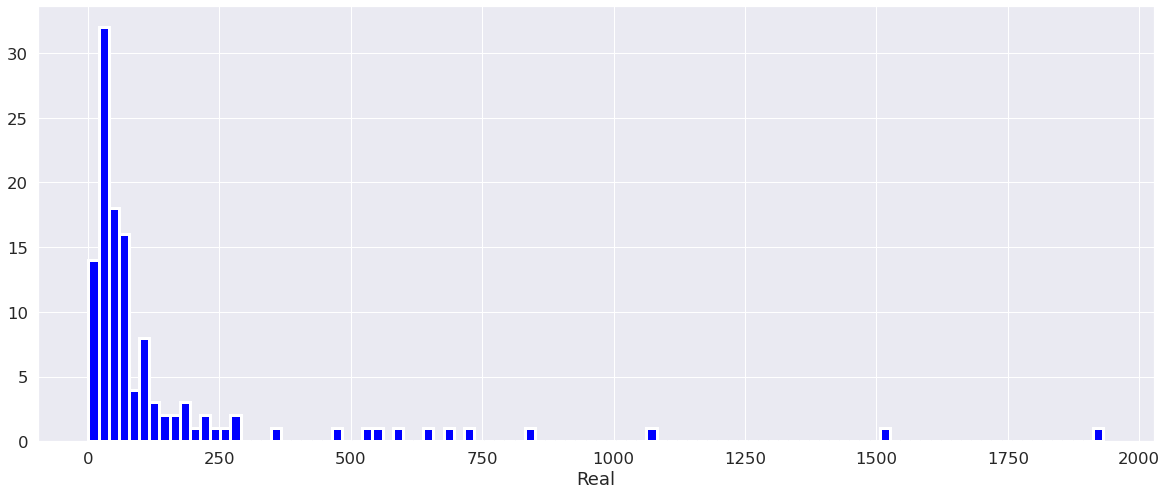

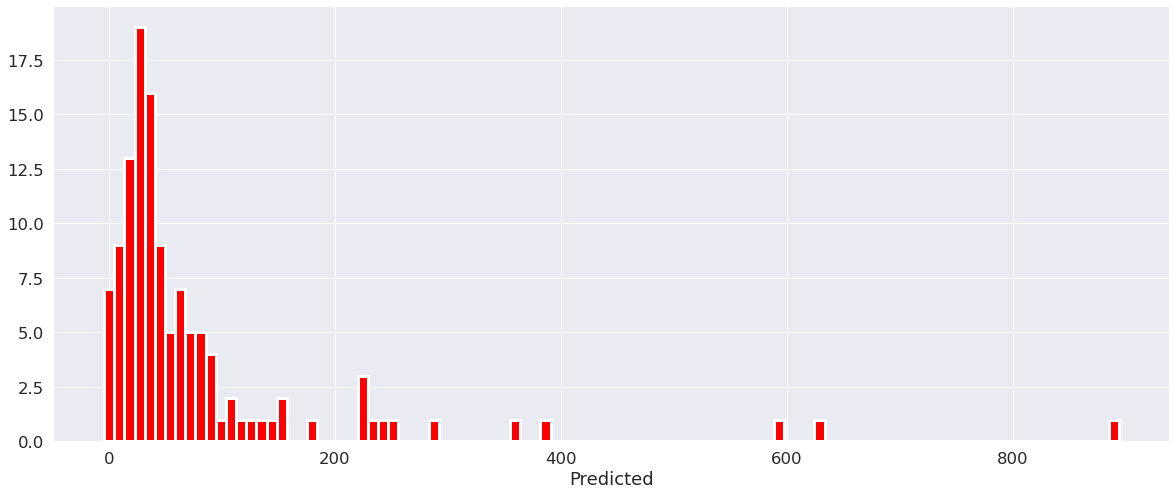


Training gb_q on set 6
Validating gb_q on set 6 and 2017-03
932 125
RMSE : 195.8495
MAPE': 1.7679
MDAPE': 0.5938
MSE: 38357.0240
MAE: 77.7920
R2: 0.3176


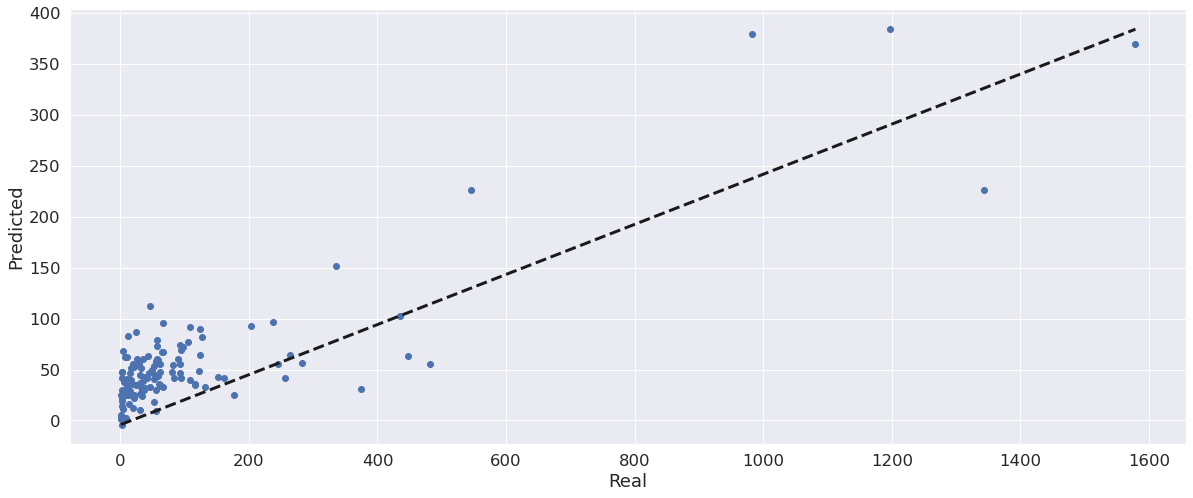

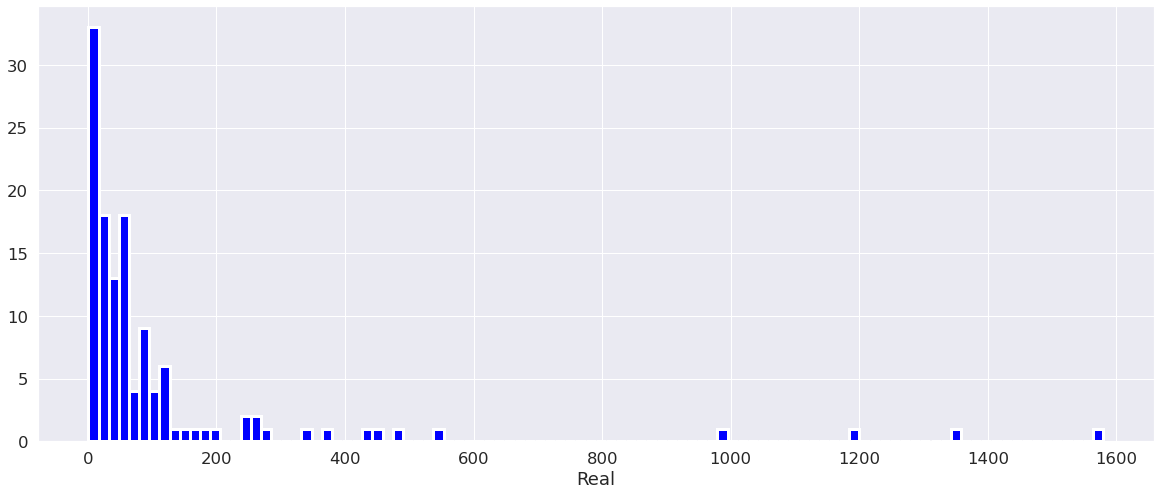

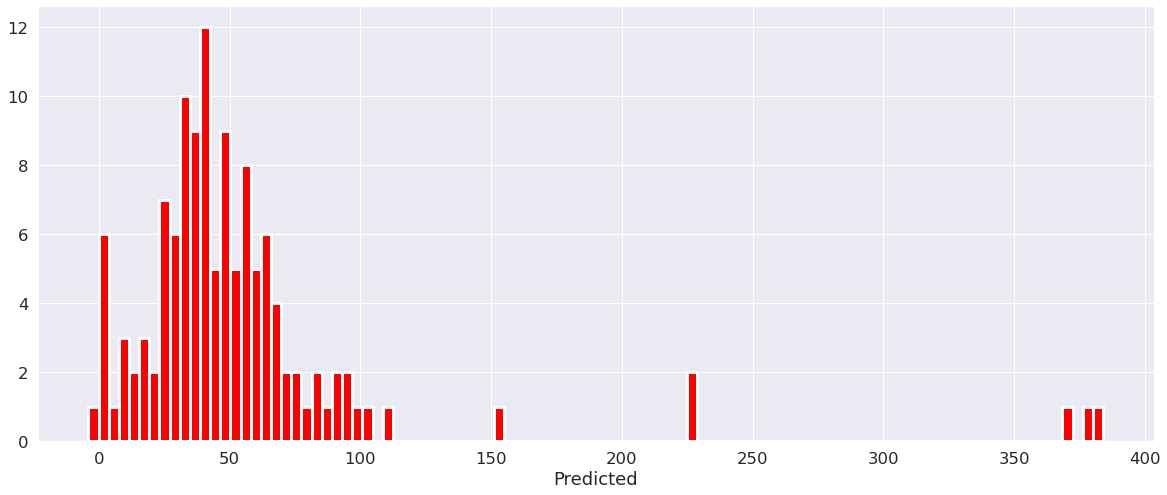


Validating gb_q on set 6 and 2017-04
932 122
RMSE : 184.9581
MAPE': 1.3318
MDAPE': 0.5765
MSE: 34209.4918
MAE: 66.4426
R2: 0.3006


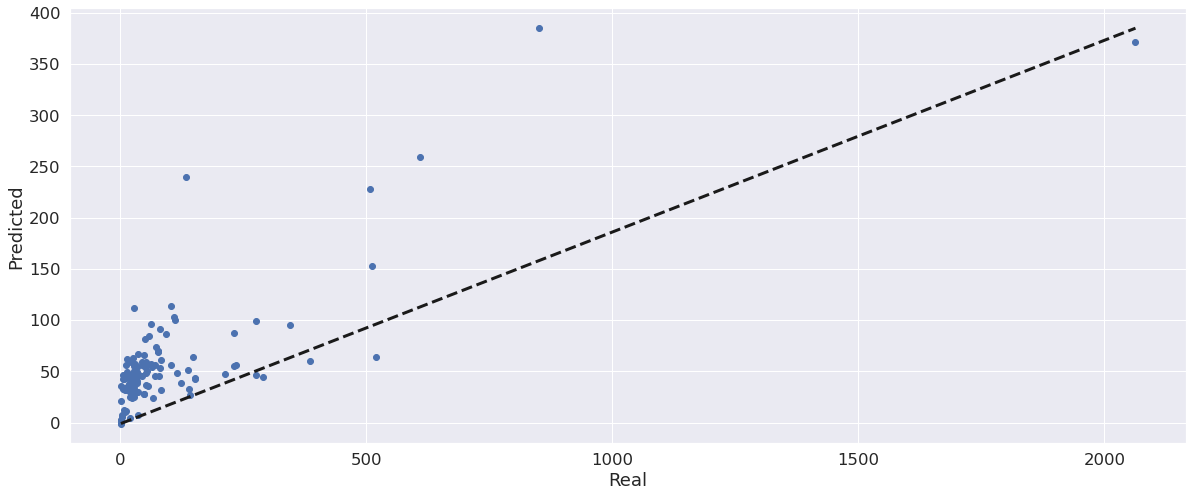

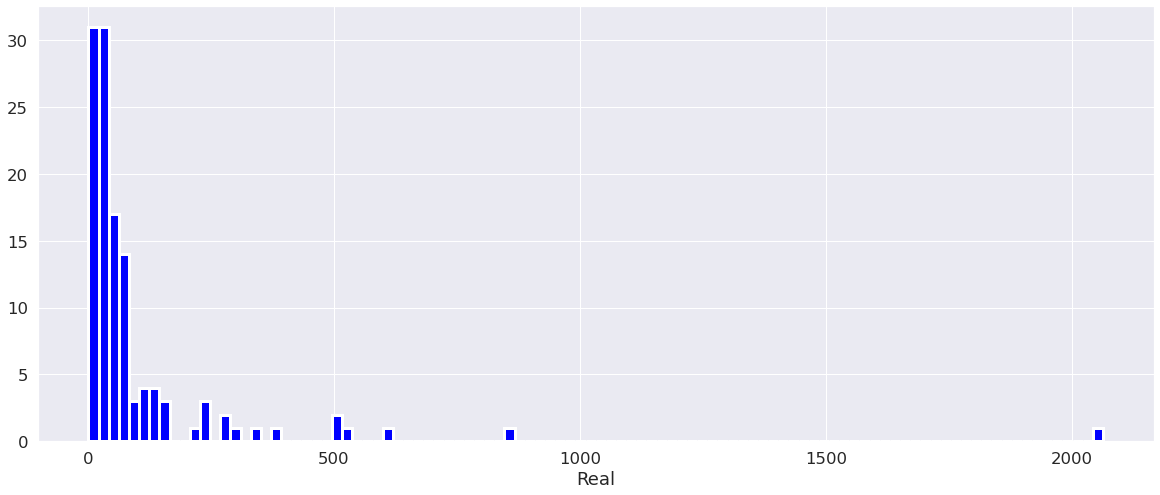

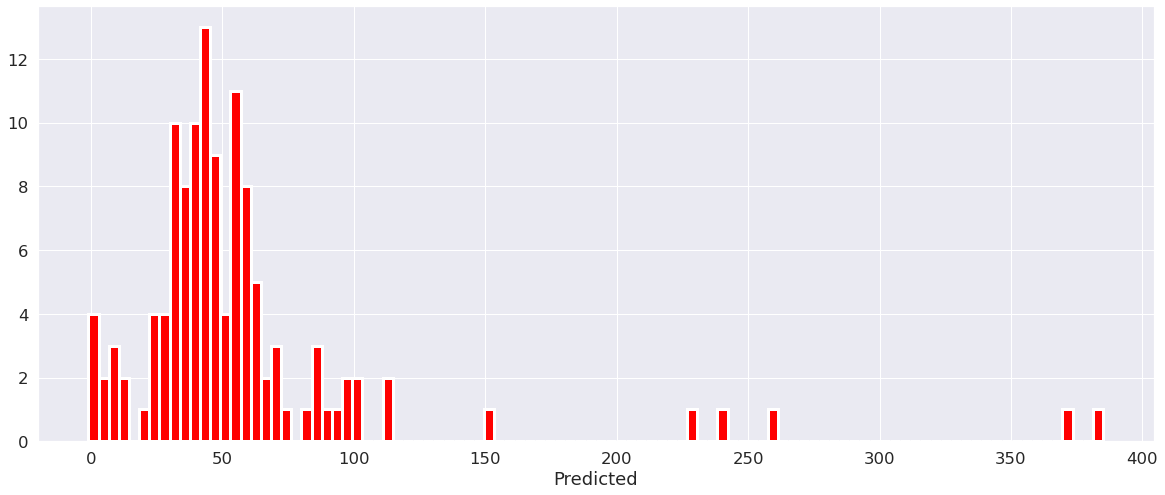


Validating gb_q on set 6 and 2017-05
932 121
RMSE : 238.3599
MAPE': 0.9713
MDAPE': 0.4907
MSE: 56815.4380
MAE: 97.1570
R2: 0.2380


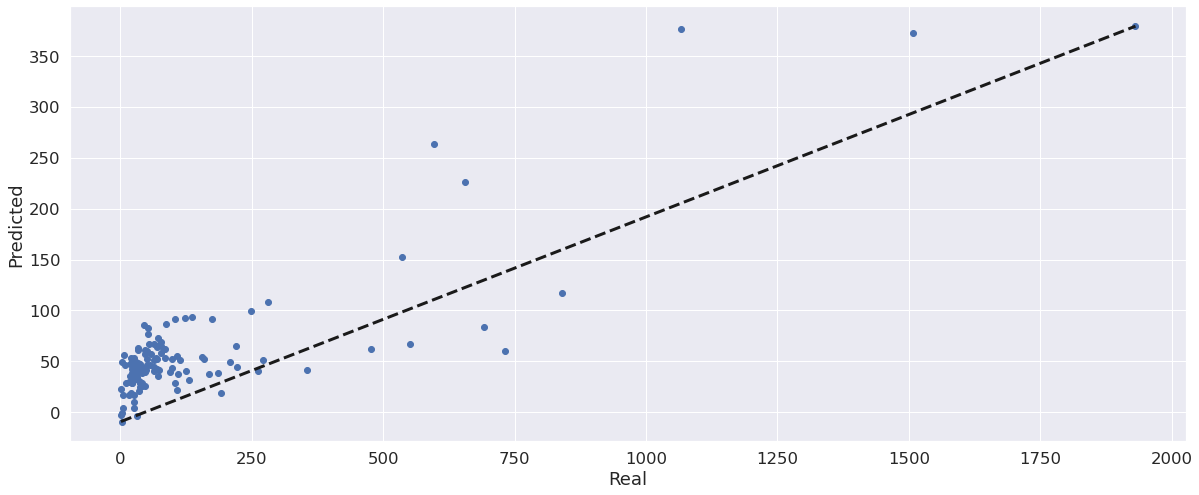

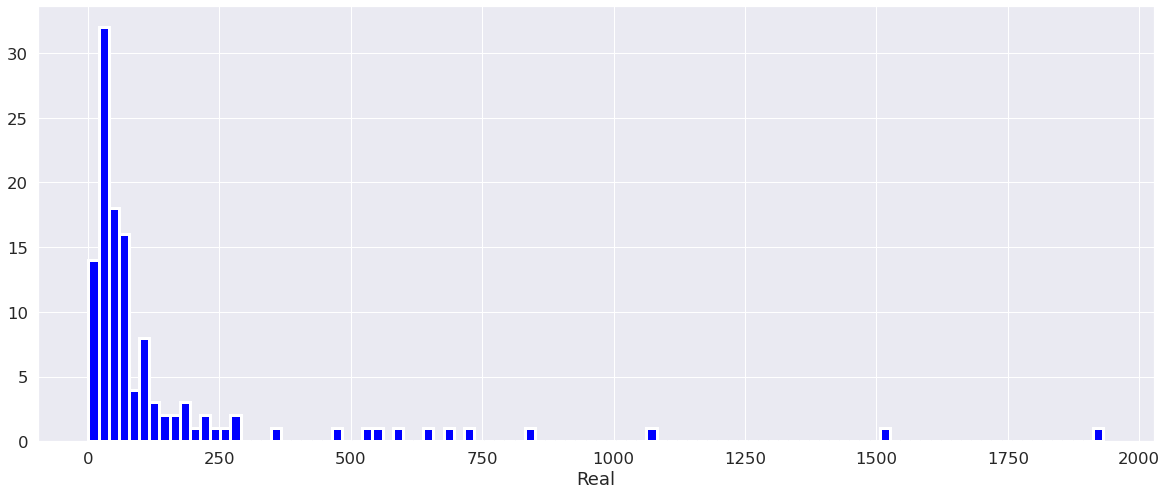

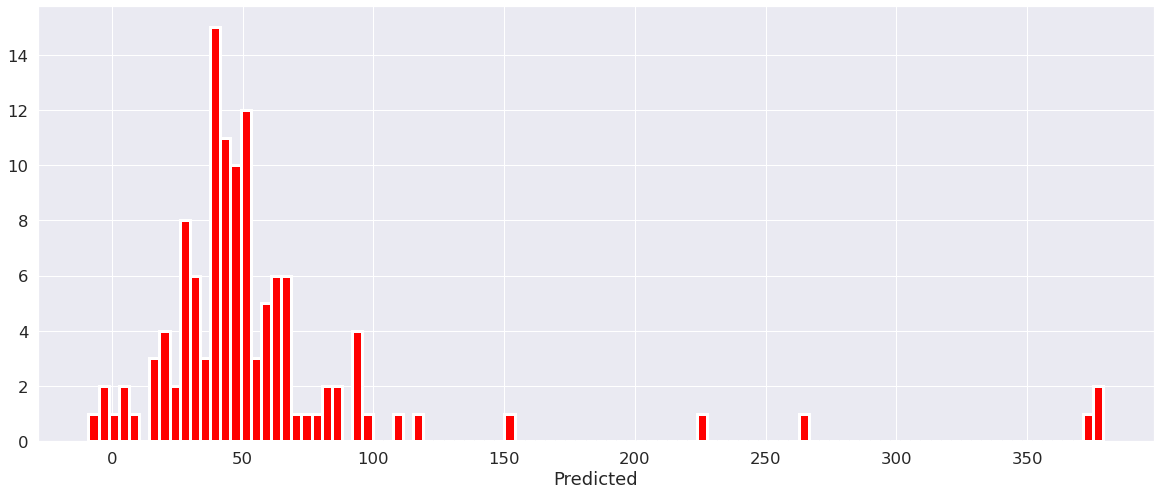

In [22]:
results = []
for r_name, r in regressors.items():
    s=6
    x_scaler = StandardScaler()

    df_set = df_train_val_test[(df_train_val_test.set == s)]

    x_scaler = MinMaxScaler()

    train_years = parse_str_list(df_set.train.values[0])
    val_years = parse_str_list(df_set.val.values[0])
    print(f'Training {r_name} on set {s}')

    df_train = df_dataset_v2[df_dataset_v2.year_month.isin(train_years)]    

    y_train = df_train['Y'].values    
    df_val = df_dataset_v2[df_dataset_v2.year_month.isin(val_years)]
    y_val = df_val['Y'].values
        
    if 'mlp' in r_name:
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train, 
                       X_val = x_scaler.transform(df_val[X_cols]), y_val = y_val)
    else: 
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train)
        
    for val_year in val_years:
        df_val = df_dataset_v2[df_dataset_v2.year_month == val_year]
        print(f'Validating {r_name} on set {s} and {val_year}')
        y_val = df_val['Y']
        y_pred_val = r_inst.predict(x_scaler.transform(df_val[X_cols]))

        y_pred_val = y_pred_val
        m = _metrics.applyRegressionMetrics(y=y_val, y_pred=y_pred_val)
        m['reg_inst'] = r_inst
        m['r_name'] = r_name
        m['set'] = s
        m['year_month'] = val_year
        results.append(m)
        print(len(y_train), len(y_val))
        _metrics.evaluateRegression(y=y_val, y_pred=y_pred_val)
        print()
df_results = pd.DataFrame(results)    

In [23]:
df_results[[c for c in df_results.columns if  c not in ['y', 'y_pred']]].sort_values('year_month')

,RMSE,MAPE,MDAPE,MSE,MAE,R2,reg_inst,r_name,set,year_month
0,175.751119,3.609783,0.876957,30888.456000,86.760000,0.450477,LGBMRegressor(random_state=42),gbm,6,2017-03
3,192.861899,2.246307,0.505376,37195.712000,75.984000,0.338267,"LGBMRegressor(alpha=0.5, metric='quantile', ob...",gbm_q,6,2017-03
6,195.849493,1.767914,0.593750,38357.024000,77.792000,0.317607,([DecisionTreeRegressor(criterion='friedman_ms...,gb_q,6,2017-03
1,139.101302,3.052609,0.800943,19349.172131,73.811475,0.604387,LGBMRegressor(random_state=42),gbm,6,2017-04
4,154.869617,1.294812,0.504386,23984.598361,65.500000,0.509611,"LGBMRegressor(alpha=0.5, metric='quantile', ob...",gbm_q,6,2017-04
7,184.958081,1.331758,0.576480,34209.491803,66.442623,0.300553,([DecisionTreeRegressor(criterion='friedman_ms...,gb_q,6,2017-04
2,201.029890,1.817903,0.739130,40413.016529,104.074380,0.457956,LGBMRegressor(random_state=42),gbm,6,2017-05
5,218.304397,1.075236,0.567164,47656.809917,93.239669,0.360798,"LGBMRegressor(alpha=0.5, metric='quantile', ob...",gbm_q,6,2017-05
8,238.359892,0.971277,0.490741,56815.438017,97.157025,0.237957,([DecisionTreeRegressor(criterion='friedman_ms...,gb_q,6,2017-05
